Driver:

    - cores: 1
    - coreLimit: "1200m"
    - memory: "2g"

Executor:

    - cores: 1
    - coreLimit: "2000m"
    - instances: 2
    - memory: "1500m"

30/05/2025
18h25
19h20

Commit 4611fbdb747d1d453882a8ddc5204f4af087a047

In [11]:
import pandas as pd
import sys
from pathlib import Path

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from functions import calculate_latencies
from utils import fix_timestamps_timezone
from charts import latency_box_plot, latency_line_plot, latency_distribution_plot

experiment_name = "experiment05"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-05-30-20_36_38-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("source_timestamp")
df_edge = pd.read_parquet(f"../../data/raw/{experiment_name}/2025-05-30-20_22_56-avro-edge.parquet")
df_edge = df_edge.sort_values("source_timestamp")

In [12]:
df_cloud = fix_timestamps_timezone(df_cloud)
df_edge = fix_timestamps_timezone(df_edge)

In [13]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [14]:
start_time = pd.Timestamp("2025-05-30 18:20:00", tz="UTC")
end_time = pd.Timestamp("2025-05-30 19:20:00", tz="UTC")

df_cloud_filtered = df_cloud[
    (df_cloud["source_timestamp"] >= start_time) &
    (df_cloud["source_timestamp"] <= end_time)
]

df_edge_filtered = df_edge[
    (df_edge["source_timestamp"] >= start_time) &
    (df_edge["source_timestamp"] <= end_time)
]

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1098: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


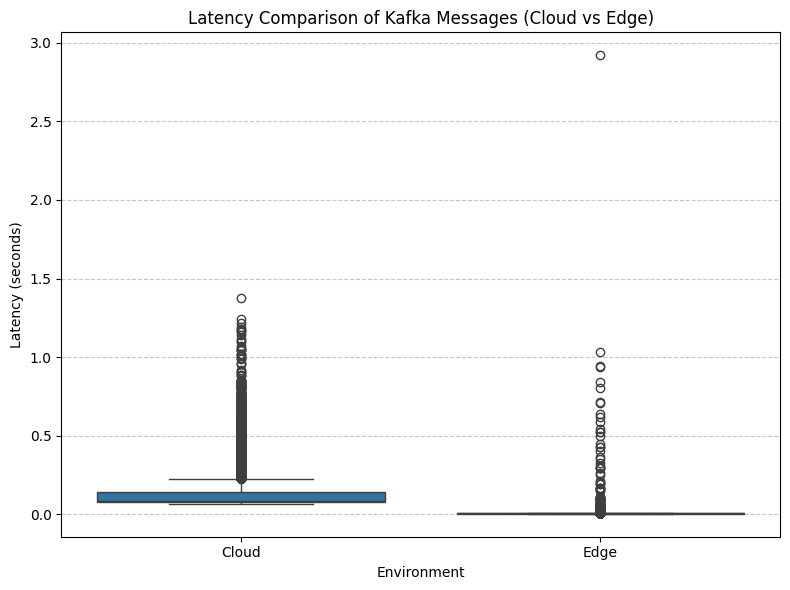

In [15]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="source_kafka_latency")

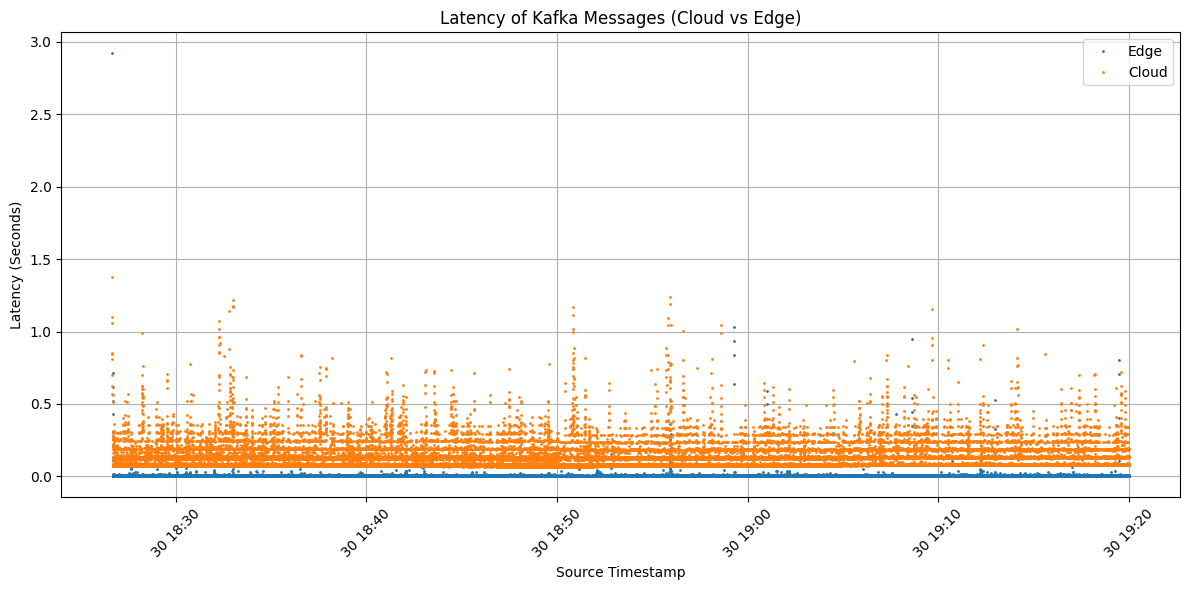

In [16]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x="source_timestamp", y="source_kafka_latency")

📊 Statistics:
                 mean    median       std
Environment                              
Cloud        0.131362  0.083083  0.092661
Edge         0.006086  0.004870  0.023942


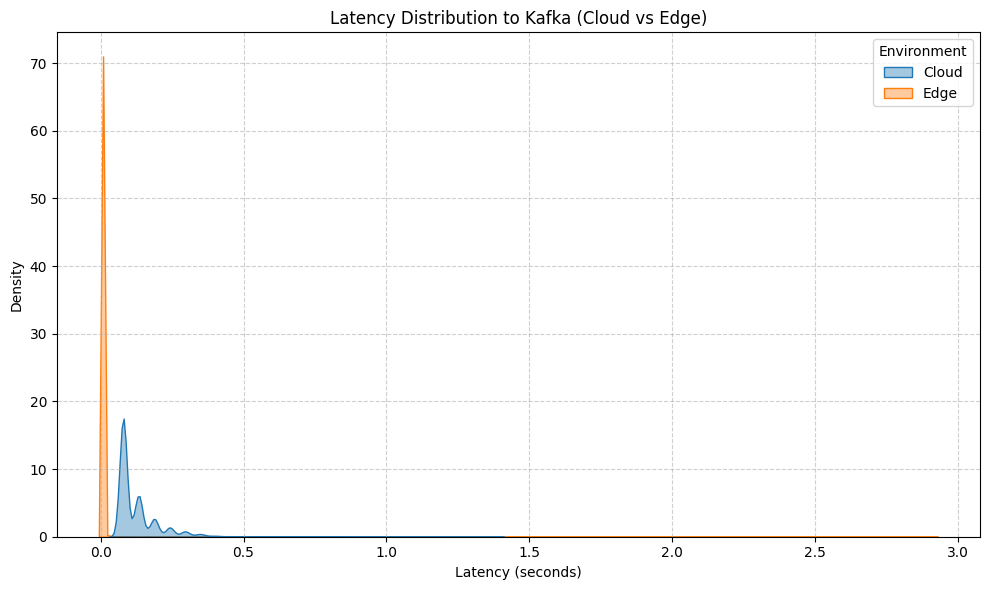

In [17]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="source_kafka_latency")

/home/arthur/dev/streaming-pipeline/notebooks/charts.py:1098: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


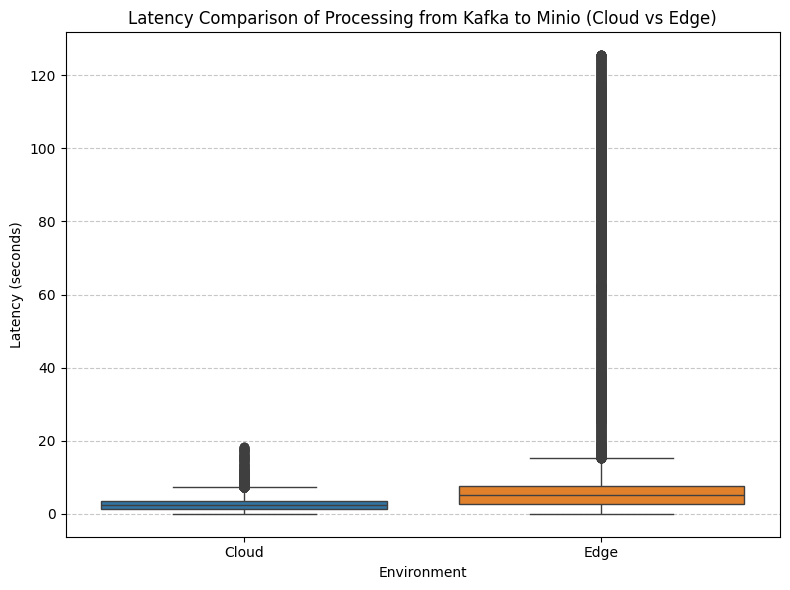

In [18]:
latency_box_plot(df_cloud_filtered, df_edge_filtered, y="kafka_landing_latency", title="Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)")

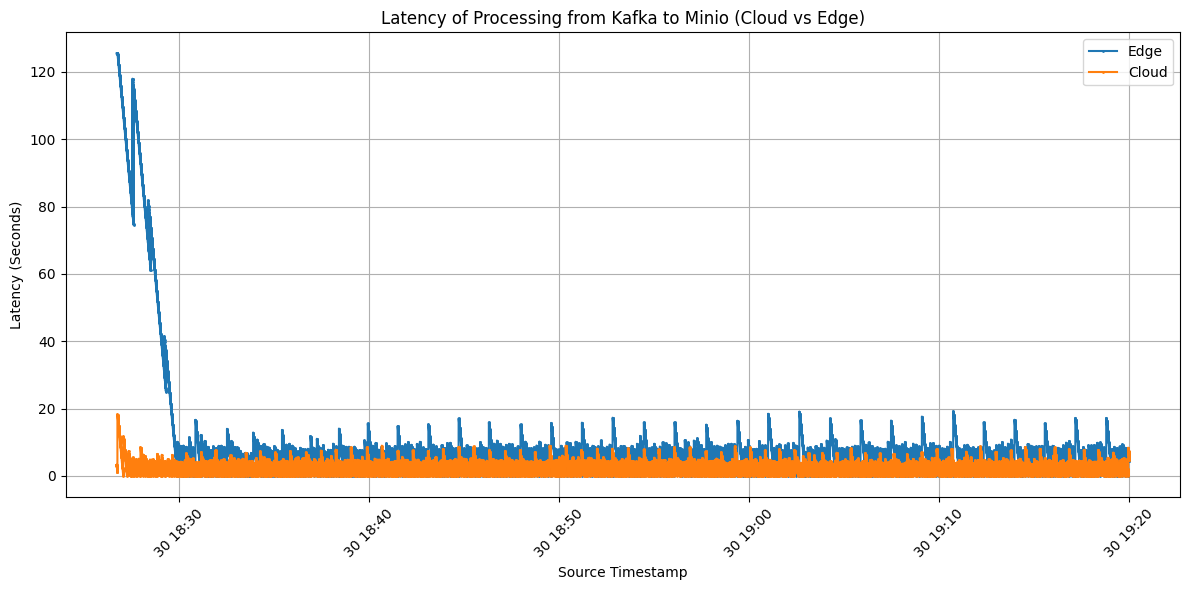

In [19]:
latency_line_plot(df_cloud_filtered, df_edge_filtered, x='source_timestamp', y='kafka_landing_latency', title='Latency of Processing from Kafka to Minio (Cloud vs Edge)', linestyle="solid")

📊 Statistics:
                 mean  median        std
Environment                             
Cloud        2.584331   2.427   1.775343
Edge         8.897339   5.099  17.553246


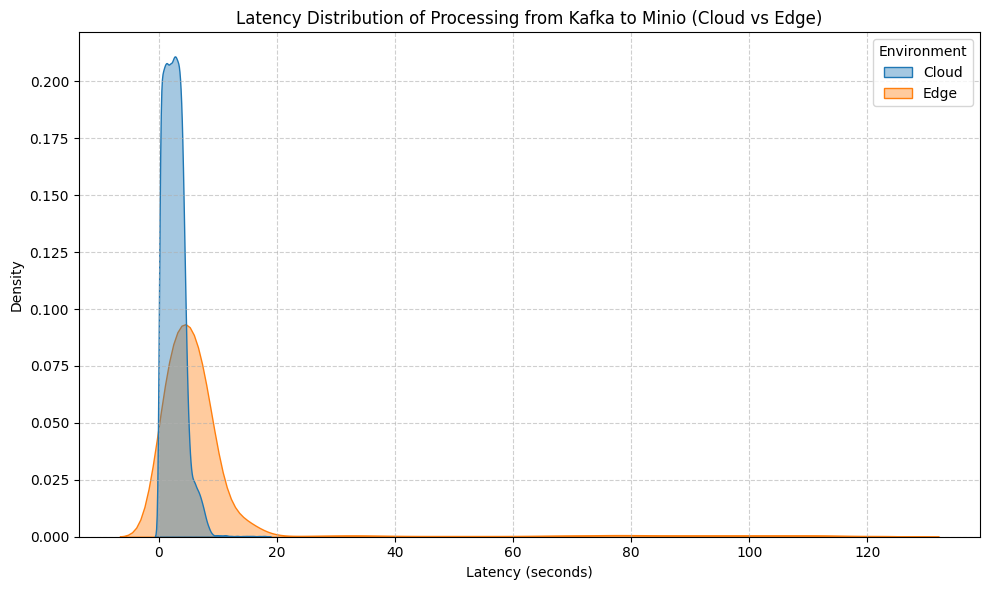

In [20]:
latency_distribution_plot(df_cloud_filtered, df_edge_filtered, x="kafka_landing_latency", title="Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)")